<a href="https://colab.research.google.com/github/17092003vamsi/guner/blob/main/final%20project%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-7-f163c7e32f9d>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Type'].fillna('', inplace=True)


Validation Accuracy: 90.08%
Test Accuracy: 90.00%


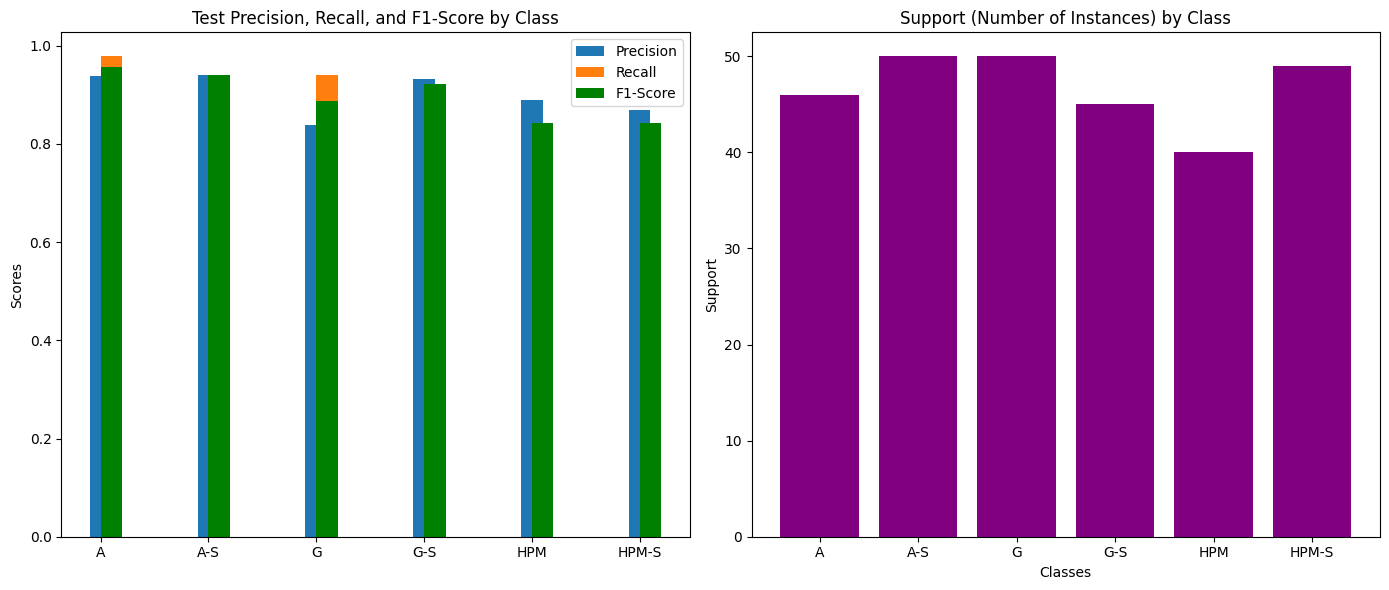

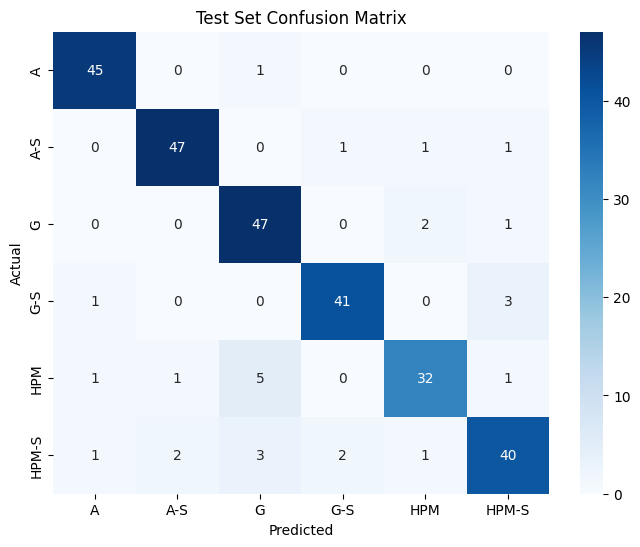

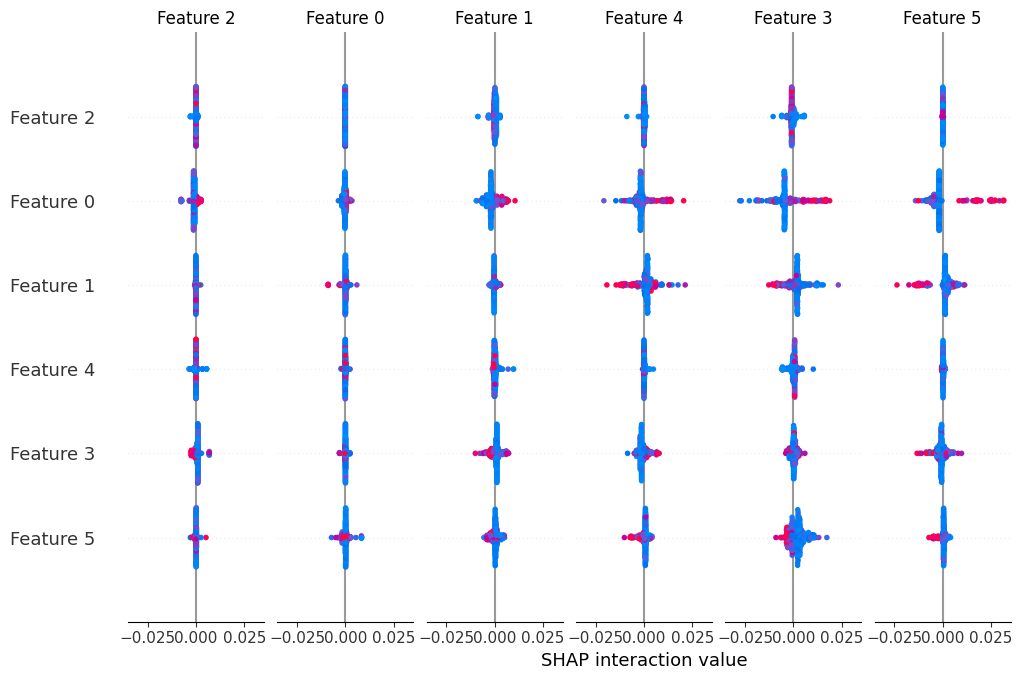

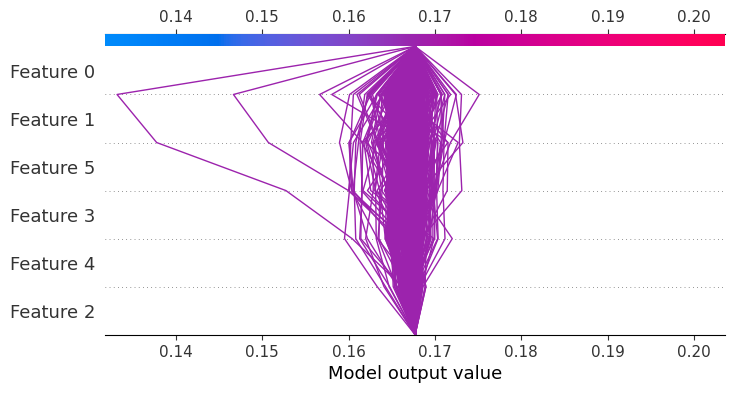

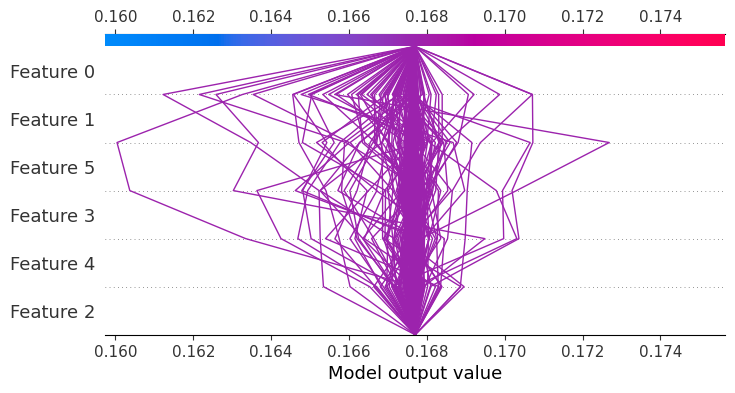

Number of classes: 6
Classes: ['A' 'A-S' 'G' 'G-S' 'HPM' 'HPM-S']
Skipping SHAP Dependence Plot for Class A due to shape mismatch or empty SHAP values.
Skipping SHAP Dependence Plot for Class A-S due to shape mismatch or empty SHAP values.
Skipping SHAP Dependence Plot for Class G due to shape mismatch or empty SHAP values.
Skipping SHAP Dependence Plot for Class G-S due to shape mismatch or empty SHAP values.
Skipping SHAP Dependence Plot for Class HPM due to shape mismatch or empty SHAP values.
Skipping SHAP Dependence Plot for Class HPM-S due to shape mismatch or empty SHAP values.


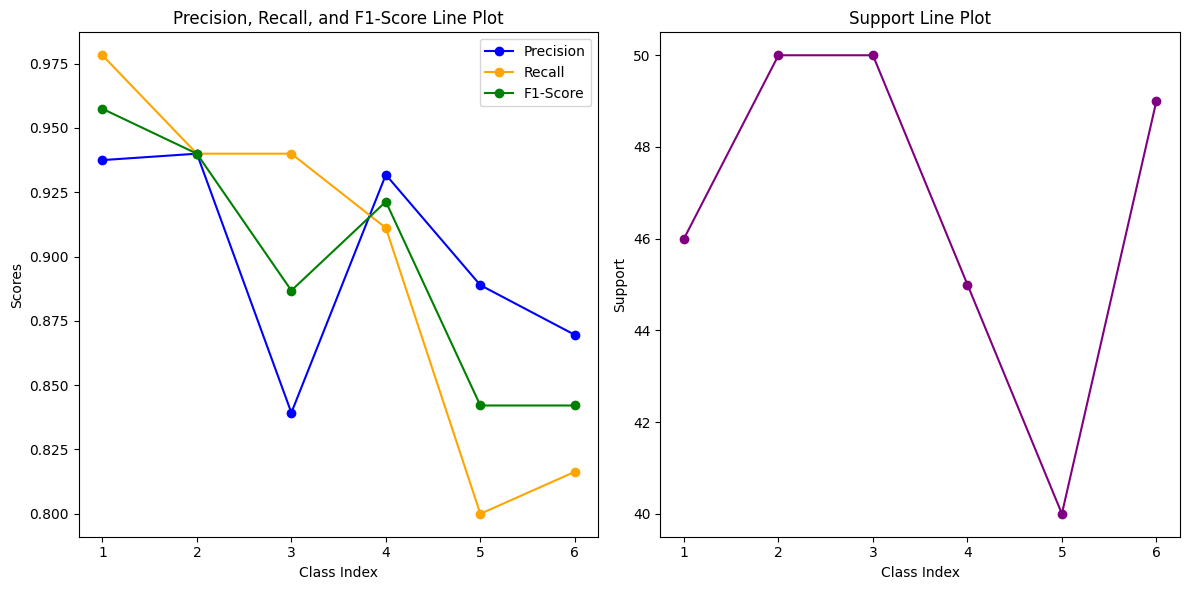

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap

# Load the dataset
file_path = 'project 2 sap.csv'  # Path to your CSV file
data = pd.read_csv(file_path)

# Preprocessing: Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Lable'])  # Encode the categorical 'Lable' column

# Fill NaN values in the 'Type' column with an empty string
data['Type'].fillna('', inplace=True)

# NLP preprocessing for the 'Type' column using TF-IDF
tfidf = TfidfVectorizer(max_features=500)  # Set max_features to limit dimensionality
X_type = tfidf.fit_transform(data['Type']).toarray()  # Transform the 'Type' column

# Combine NLP features with existing numerical data
X_numeric = data.drop(columns=['Type', 'Lable']).values  # Drop 'Type' and 'Lable' columns for numerical data
X = np.hstack((X_numeric, X_type))  # Combine numerical and NLP features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a validation set from the training data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_split, y_train_split)

# Predict on validation and test sets
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Accuracy on validation and test sets
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Display validation and test accuracy
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Get unique classes from predictions
unique_classes = np.unique(y_pred_test)

# Extract class names corresponding to unique classes
target_names = label_encoder.inverse_transform(unique_classes)

# Classification report
class_report = classification_report(y_test, y_pred_test, target_names=target_names, output_dict=True)

# Extract precision, recall, f1-score, and support for each class
precision = [class_report[label]['precision'] for label in target_names]
recall = [class_report[label]['recall'] for label in target_names]
f1_score = [class_report[label]['f1-score'] for label in target_names]
support = [class_report[label]['support'] for label in target_names]

### Step 1: Plot Precision, Recall, F1-Score (Bar Chart) ###
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for precision, recall, f1-score
x_labels = target_names

ax[0].bar(x_labels, precision, width=0.2, label='Precision', align='center')
ax[0].bar(x_labels, recall, width=0.2, label='Recall', align='edge')
ax[0].bar(x_labels, f1_score, width=0.2, label='F1-Score', align='edge', color='green')

ax[0].set_title('Test Precision, Recall, and F1-Score by Class')
ax[0].set_ylabel('Scores')
ax[0].legend()

# Bar plot for support
ax[1].bar(x_labels, support, color='purple')
ax[1].set_title('Support (Number of Instances) by Class')
ax[1].set_ylabel('Support')
ax[1].set_xlabel('Classes')

plt.tight_layout()
plt.show()

### Step 2: Plot Confusion Matrix (Heatmap) ###
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Test Set Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Step 3: SHAP Plots ###
# SHAP explainability analysis
explainer = shap.TreeExplainer(model)
shap_values_test = explainer.shap_values(X_test)

# SHAP summary plot (global feature importance)
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

# SHAP decision plot with ignore_warnings set to True
shap.decision_plot(explainer.expected_value[1], shap_values_test[1], X_test, ignore_warnings=True)

# OR using subsampling for decision plot
num_samples = min(500, X_test.shape[0])  # Use the smaller of 500 or the size of X_test
sample_indices = np.random.choice(range(X_test.shape[0]), size=num_samples, replace=False)

# SHAP Decision Plot with subsampling
shap.decision_plot(
    explainer.expected_value[1],
    shap_values_test[1][sample_indices],
    X_test[sample_indices],
    show=True
)

# Loop through each class to create SHAP dependence plots
print(f'Number of classes: {len(label_encoder.classes_)}')
print(f'Classes: {label_encoder.classes_}')

for class_index in range(len(shap_values_test)):
    if class_index < len(label_encoder.classes_):
        if shap_values_test[class_index].size > 0 and shap_values_test[class_index].shape[0] == X_test.shape[0]:
            print(f"Generating SHAP Dependence Plot for Class {label_encoder.classes_[class_index]}")
            shap.dependence_plot(0, shap_values_test[class_index], X_test, interaction_index=1)
        else:
            print(f"Skipping SHAP Dependence Plot for Class {label_encoder.classes_[class_index]} due to shape mismatch or empty SHAP values.")

### Step 4: Plot Precision, Recall, F1-Score, Accuracy (Line Graphs) ###
epochs = np.arange(1, len(precision) + 1)

plt.figure(figsize=(12, 6))

# Line plot for precision, recall, and f1-score
plt.subplot(1, 2, 1)
plt.plot(epochs, precision, label='Precision', marker='o', color='blue')
plt.plot(epochs, recall, label='Recall', marker='o', color='orange')
plt.plot(epochs, f1_score, label='F1-Score', marker='o', color='green')
plt.xlabel('Class Index')
plt.ylabel('Scores')
plt.legend()
plt.title('Precision, Recall, and F1-Score Line Plot')

# Line plot for support
plt.subplot(1, 2, 2)
plt.plot(epochs, support, label='Support', marker='o', color='purple')
plt.xlabel('Class Index')
plt.ylabel('Support')
plt.title('Support Line Plot')

plt.tight_layout()
plt.show()
